# Transliteration From English To Hindi Using Seq2Seq model 

### The model intends to pedict the english transliteration for hindi data. The data is downloaded from [here](https://github.com/anoopkunchukuttan/crowd-indic-transliteration-data)

In [23]:
import string
import numpy as np
import tensorflow as tf
import tempfile
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [38]:
# Give some special vocabulary symbols - append them at the start of each text.
_PAD = "_PAD"
_GO = "_GO"
_EOS = "_EOS"
_UNK = "_UNK"
_START_CHARS = [_PAD, _GO, _EOS, _UNK]

PAD_ID = 0
GO_ID = 1
EOS_ID = 2
UNK_ID = 3

In [39]:
def get_transliteration_pairs(file_name):
    """Read the file and get the hindi english pairs"""
    en_hi_lines = open(file_name).read().strip().split('\n')
    en_hi_pairs = [[x.strip().lower() for x in line.split('\t')]
                   for line in en_hi_lines]

    return en_hi_pairs

In [40]:
def word_to_char_ids(word, char_dict, length=15):
    """Replace each character in the word to its respective ids using the char_dict
    """
    char_ids = [char_dict.get(x, UNK_ID) for x in word] + [EOS_ID]
    if len(char_ids) < length:
        char_ids += [PAD_ID] * (length - len(char_ids))
    return char_ids

def get_char_vocab(script):
    """
    Provide the unique number to each letters in both hindi and english language
    """
    if script == 'devanagari':
        chars = _START_CHARS + list(map(chr, range(0x900, 0x97F)))
    else:
        chars = _START_CHARS + list(string.ascii_letters)
    chars_dict = {x: i for i, x in enumerate(chars)}
    return chars, chars_dict

In [41]:

def data_generator(data):
    en_hi_pairs=get_transliteration_pairs(data)
    bucket=(16, 16)
    pairs = [x for x in en_hi_pairs if
                    len(x[0]) + 1 < bucket[0] and
                    len(x[1]) + 1 < bucket[1]]
    en_chars, en_dict = get_char_vocab('latin')
    hi_chars, hi_dict = get_char_vocab('devanagari')
    eng_length=len(en_dict.keys())
    hin_length=len(hi_dict.keys())
    """
    Vectorise and eaqulise the whole training set
    """
    np.random.shuffle(pairs)
    for i in range(0, len(pairs)):
        eng_values = [word_to_char_ids(word_pair[0], en_dict, bucket[0])
                      for word_pair in pairs[i:i + len(pairs)]]
        hin_values = [word_to_char_ids(word_pair[1],hi_dict, bucket[1])
                 for word_pair in pairs[i:i + len(pairs)]]
        return hin_values,eng_values,hin_length,eng_length

In [42]:
X,Y,hin_vocab,eng_vocab=data_generator("Hindi - Word Transliteration Pairs 1.txt")

In [43]:
#convert the lists to numpy array
X=np.array(X)
Y=np.array(Y)

## Split the data

Split the data to train and test. Use 80% of data to train and rest to test 

In [45]:
from sklearn.model_selection import train_test_split

# split data into train and test set
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.2, random_state = 0)

# Model Architecture

It is a seq2seq model consist 'encoder' and 'decoder'. The encoder consist LSTM network preceded by an embedding layer. The decoder, LSTM network followed by dense layer.

In [32]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [33]:
model = define_model(hin_vocab, eng_vocab, 16, 16, 512)

In [34]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

# Run and Save the model

In [35]:
filename = 'model.h1.hi_en'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(xTrain, yTrain.reshape(yTrain.shape[0], yTrain.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 19708 samples, validate on 4927 samples
Epoch 1/30
19708/19708 [==============================] - 65s 3ms/step - loss: 1.8885 - val_loss: 1.5132

Epoch 00001: val_loss improved from inf to 1.51318, saving model to model.h1.29_jan_91
Epoch 2/30
19708/19708 [==============================] - 62s 3ms/step - loss: 1.4901 - val_loss: 1.6540

Epoch 00002: val_loss did not improve from 1.51318
Epoch 3/30
19708/19708 [==============================] - 62s 3ms/step - loss: 1.3982 - val_loss: 1.2915

Epoch 00003: val_loss improved from 1.51318 to 1.29151, saving model to model.h1.29_jan_91
Epoch 4/30
19708/19708 [==============================] - 62s 3ms/step - loss: 1.2672 - val_loss: 1.2312

Epoch 00004: val_loss improved from 1.29151 to 1.23123, saving model to model.h1.29_jan_91
Epoch 5/30
19708/19708 [==============================] - 62s 3ms/step - loss: 1.

# Plot the loss

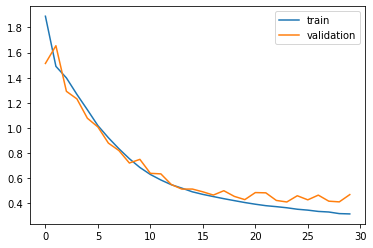

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()